# Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor,GradientBoostingRegressor,BaggingRegressor
from sklearn.ensemble import VotingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from sklearn.preprocessing import StandardScaler,MinMaxScaler,RobustScaler
from sklearn.model_selection import train_test_split,KFold,cross_val_score,GridSearchCV,RandomizedSearchCV
from sklearn.feature_selection import RFE

from sklearn.preprocessing import LabelEncoder

import xgboost

from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_log_error

pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)

import warnings
warnings.filterwarnings(action='ignore')

import scipy
from matplotlib import pylab
from pylab import *
from scipy.special import boxcox,inv_boxcox

In [2]:
df = pd.read_excel('train.xlsx')
test = pd.read_excel('test.xlsx')
df.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


In [3]:
df.describe(include=np.object)

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info
count,10683,10683,10683,10683,10682,10683,10683,10683,10682,10683
unique,12,44,5,6,128,222,1343,368,5,10
top,Jet Airways,18/05/2019,Delhi,Cochin,DEL → BOM → COK,18:55,19:00,2h 50m,1 stop,No info
freq,3849,504,4537,4537,2376,233,423,550,5625,8345


# Checking for Duplicates

In [4]:
print('Train Data Orignal Size {}\n'.format(df.shape))
if(any(df.duplicated())==True):
    print('Duplicate rows found')
    print('Number of duplicate rows= ',df[df.duplicated()].shape[0])
    df.drop_duplicates(inplace=True,keep='first')
    df.reset_index(inplace=True,drop=True)
    print('Dropping duplicates')
    print(df.shape)
else:
    print('NO duplicate data')

Train Data Orignal Size (10683, 11)

Duplicate rows found
Number of duplicate rows=  220
Dropping duplicates
(10463, 11)


# Checking for Missing Data

In [5]:
print('TRAIN DATA- ',end=' ')
if(any(df.isnull().any())):
    print('Missing Data\n')
    print(df.isnull().sum())
else:
    print('NO missing data')
    
print('\nTEST DATA- ',end=' ')
if(any(test.isnull().any())):
    print('Missing Data\n')
    print(test.isnull().sum())
else:
    print('NO missing data')

TRAIN DATA-  Missing Data

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              1
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        1
Additional_Info    0
Price              0
dtype: int64

TEST DATA-  NO missing data


# Dealing with Missing Data

## `Only 1 Row Missing Data, so simply drop the Row or Impute using Mode`

In [6]:
# since there is only one row with missing data we can drop it or impute it using the mode

# df.dropna(inplace=True)

#idx = df['Route'].isna().tolist().index(True)
#print(df.loc[idx])
#df[(df['Source']=='Delhi') & (df['Destination']=='Cochin')]['Route'].value_counts()

df['Route'].fillna('DEL → BOM → COK',inplace=True)
df['Total_Stops'].fillna('1 stop',inplace=True)

# Exploratory Data Analysis (EDA)

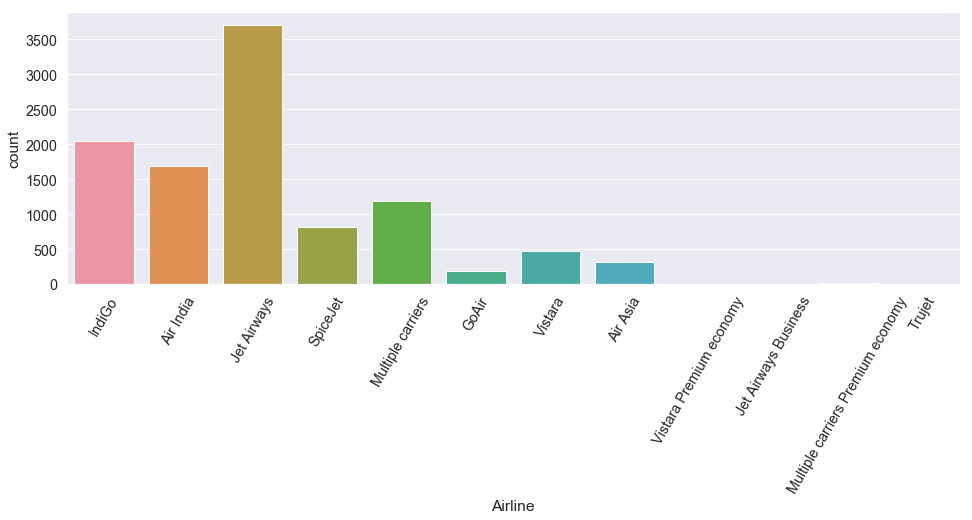

In [7]:
sns.set(font_scale=1.3)
plt.figure(figsize=(16,5))
sns.countplot(df['Airline'])
plt.xticks(rotation=60);

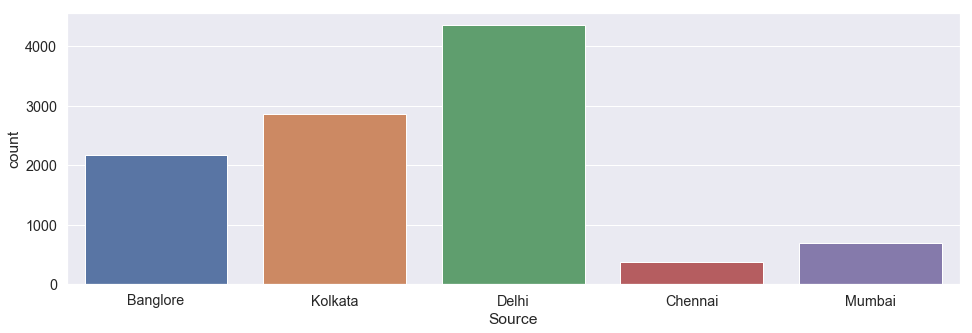

In [8]:
sns.set(font_scale=1.3)
plt.figure(figsize=(16,5))
sns.countplot(df['Source']);

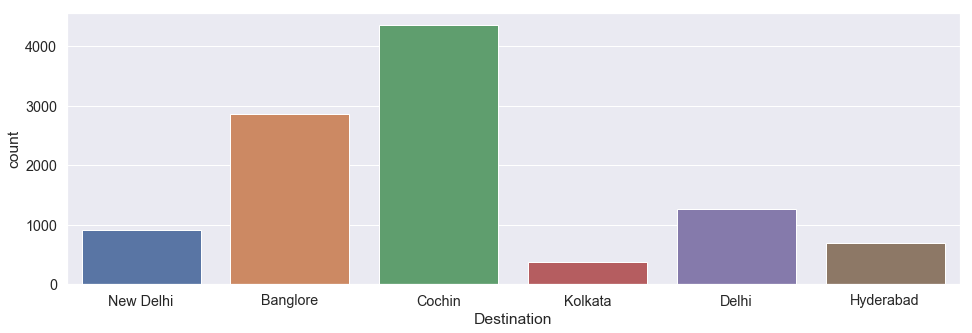

In [9]:
sns.set(font_scale=1.3)
plt.figure(figsize=(16,5))
sns.countplot(df['Destination']);

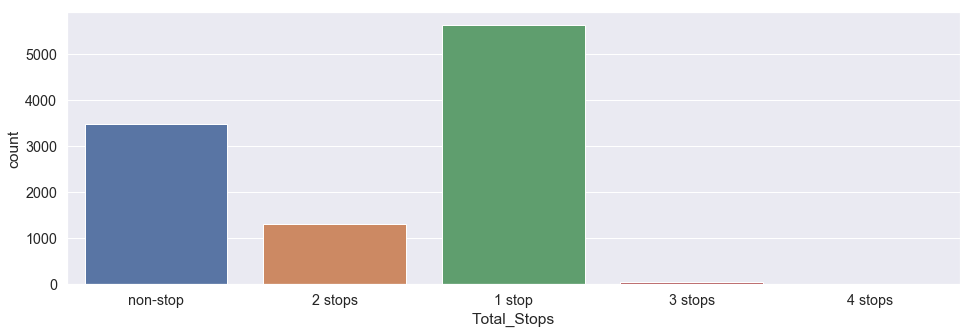

In [10]:
sns.set(font_scale=1.3)
plt.figure(figsize=(16,5))
sns.countplot(df['Total_Stops']);

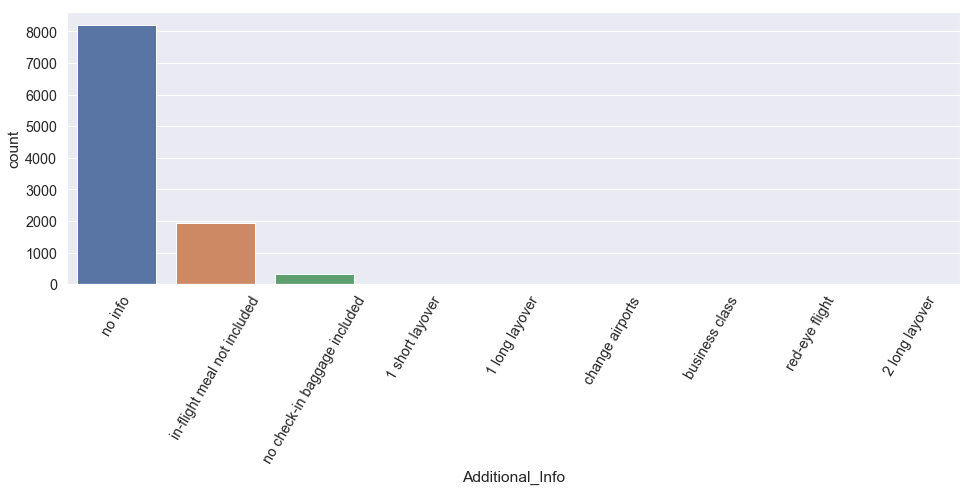

In [11]:
df['Additional_Info'] = df['Additional_Info'].apply(lambda x:x.lower())
test['Additional_Info'] = test['Additional_Info'].apply(lambda x:x.lower())
sns.set(font_scale=1.3)
plt.figure(figsize=(16,5))
sns.countplot(df['Additional_Info'])
plt.xticks(rotation=60);

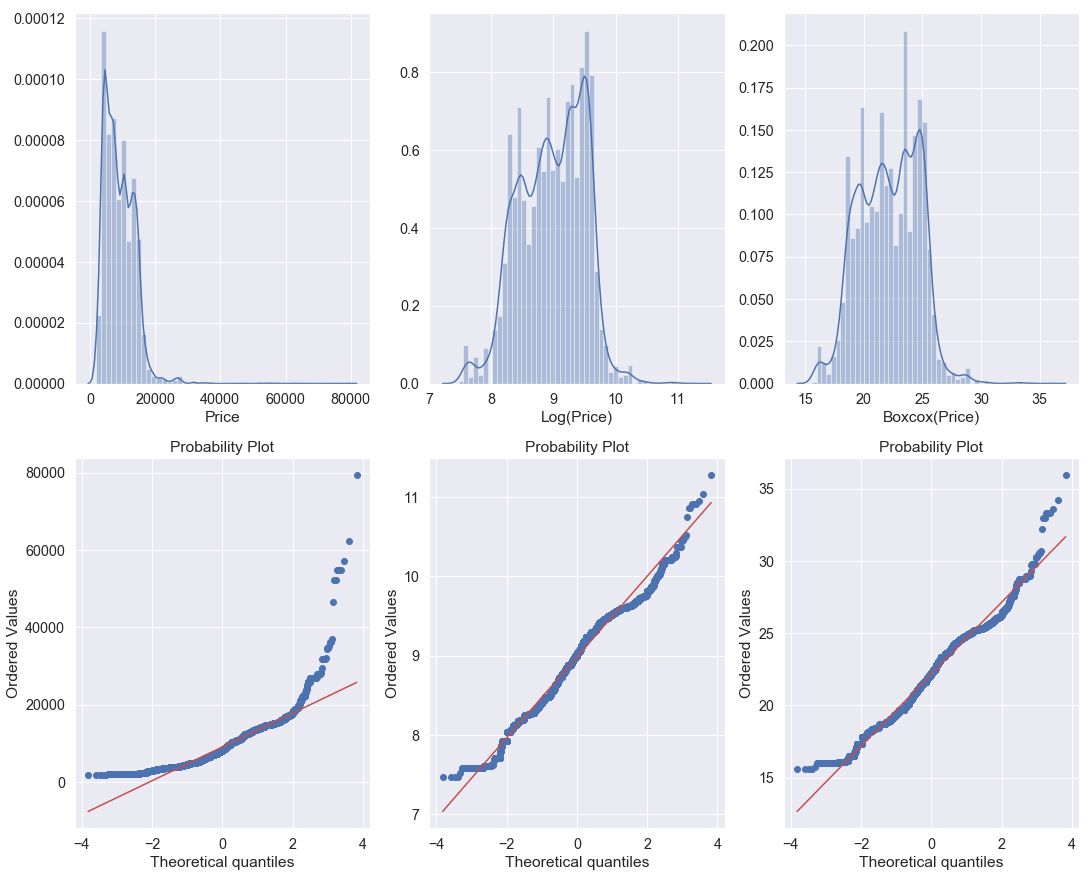

In [12]:
plt.figure(figsize=(18,15))

plt.subplot(231)
sns.distplot(df['Price'])

plt.subplot(232)
sns.distplot(np.log(df['Price']))
plt.xlabel('Log(Price)')

plt.subplot(233)
x=scipy.stats.boxcox(df['Price'])
sns.distplot(x[0])
plt.xlabel('Boxcox(Price)')

plt.subplot(234)
scipy.stats.probplot(df['Price'], dist="norm", plot=pylab)

plt.subplot(235)
scipy.stats.probplot(np.log(df['Price']), dist="norm", plot=pylab)

plt.subplot(236)
# x=scipy.stats.boxcox(df['Price'])
# sns.distplot(x[0])
scipy.stats.probplot(scipy.stats.boxcox(df['Price'])[0], dist="norm", plot=pylab);

# Doing boxcox transformation of Target Variable (Price)

In [13]:
group = df.groupby('Airline')
group.describe()
group.describe().sort_values([('Price','mean')],ascending=False)

Price                                                                          
                                    count          mean           std      min      25%      50%       75%      max
Airline                                                                                                            
Jet Airways Business               6.0     58358.666667  11667.596748  46490.0  52243.0  54747.0  61122.50  79512.0
Jet Airways                        3700.0  11599.021081  4315.671402   1840.0   8586.0   11134.0  14151.00  54826.0
Multiple carriers Premium economy  13.0    11418.846154  1717.153936   9845.0   10161.0  11269.0  11269.00  14629.0
Multiple carriers                  1196.0  10902.678094  3721.234997   5797.0   7723.0   10197.0  13587.00  36983.0
Air India                          1695.0  9555.382891   3937.036277   2050.0   6602.5   9292.0   12199.00  31945.0
Vistara Premium economy            3.0     8962.333333   2915.405518   5969.0   7547.0   9125.0   10459.00  11793.0
Vistara                            478.0   7801.355649   2915.288625   3687.0   5403.0   7980.0   9345.00   21730.0
GoAir                              194.0   5861.056701   2703.585767   3398.0   3898.0   5135.0   6811.25   22794.0
IndiGo                             2043.0  5668.469897   2266.933697   2227.0   4226.0   5000.0   6493.00   22153.0
Air Asia                           319.0   5590.260188   2027.362290   3383.0   4282.0   5162.0   6451.00   13774.0
SpiceJet                           815.0   4335.841718   1851.144678   1759.0   3573.0   3873.0   4760.00   23267.0
Trujet                             1.0     4140.000000  NaN            4140.0   4140.0   4140.0   4140.00   4140.0

In [14]:
# I have also tried Standard Scaler & MinMaxScaler but results were best for boxcox
df['Price'] ,lam = scipy.stats.boxcox(df['Price'])

# Dealing with Categorical Data

In [15]:
df['Total_Stops'] = df['Total_Stops'].map({'non-stop':0,'1 stop':1,'2 stops':2,'3 stops':3,'4 stops':4})
test['Total_Stops'] = test['Total_Stops'].map({'non-stop':0,'1 stop':1,'2 stops':2,'3 stops':3,'4 stops':4})

lab_enc = LabelEncoder()
df['Airline']=lab_enc.fit_transform(df['Airline'])
test['Airline']=lab_enc.transform(test['Airline'])

df['Source']=lab_enc.fit_transform(df['Source'])
test['Source']=lab_enc.transform(test['Source'])

df['Destination']=lab_enc.fit_transform(df['Destination'])
test['Destination']=lab_enc.transform(test['Destination'])

df['Additional_Info']=lab_enc.fit_transform(df['Additional_Info'])
test['Additional_Info']=lab_enc.transform(test['Additional_Info'])

# Feature Engineering

In [16]:
df['Dep_Time_hour'] = pd.to_datetime(df['Dep_Time']).dt.hour
test['Dep_Time_hour'] = pd.to_datetime(test['Dep_Time']).dt.hour
df['Dep_Time_min'] = pd.to_datetime(df['Dep_Time']).dt.minute
test['Dep_Time_min'] = pd.to_datetime(test['Dep_Time']).dt.minute

df['Arr_Time_hour'] = pd.to_datetime(df['Arrival_Time']).dt.hour
test['Arr_Time_hour'] = pd.to_datetime(test['Arrival_Time']).dt.hour
df['Arr_Time_min'] = pd.to_datetime(df['Arrival_Time']).dt.minute
test['Arr_Time_min'] = pd.to_datetime(test['Arrival_Time']).dt.minute

df['journey_date']=pd.to_datetime(df['Date_of_Journey'],format = '%d/%m/%Y').dt.day
test['journey_date']=pd.to_datetime(test['Date_of_Journey'],format = '%d/%m/%Y').dt.day

df['Date_of_Journey'] = pd.to_datetime(df['Date_of_Journey'])
test['Date_of_Journey'] = pd.to_datetime(test['Date_of_Journey'])

# year only 2019

x=df['Date_of_Journey']
df['month'] = x.dt.month
df['weekday']=x.dt.weekday_name
df['weekend']=df['weekday'].apply(lambda x: 1 if x in ['Saturday','Sunday'] else 0)
df['weekday']= x.dt.weekday
df['week'] = x.dt.weekofyear

x=test['Date_of_Journey']
test['month'] = x.dt.month
test['weekday']=x.dt.weekday_name
test['weekend']=test['weekday'].apply(lambda x: 1 if x in ['Saturday','Sunday'] else 0)
test['weekday']= x.dt.weekday
test['week'] = x.dt.weekofyear

df.drop(columns='Date_of_Journey',inplace=True)
test.drop(columns='Date_of_Journey',inplace=True)

df.drop(columns=['Dep_Time','Arrival_Time'],inplace=True)
test.drop(columns=['Dep_Time','Arrival_Time'],inplace=True)

In [17]:
def duration_minutes(dur):
    time = dur.split()
    ans=0
    if(len(time)==2):
        ans += int(time[0].rstrip('h')) * 60
        ans += int(time[1].rstrip('m'))
    else:
        if(time[0][-1]=='h'):
            ans+= int(time[0].rstrip('h')) * 60
        else:
            ans += int(time[0].rstrip('m'))
            
    return ans

df['Duration'] = df['Duration'].apply(lambda x:x.lower())
test['Duration'] = test['Duration'].apply(lambda x:x.lower())

df['Duration_minutes'] = df['Duration'].apply(duration_minutes)
test['Duration_minutes'] = test['Duration'].apply(duration_minutes)

df.drop(columns=['Duration','Route'],inplace=True)
test.drop(columns=['Duration','Route'],inplace=True)

In [18]:
def time_bins(i):
    if(4<=i<=11):
        return 0
    elif(12<=i<=15):
        return 1
    elif(16<=i<=19):
        return 2
    else:
        return 3

df['depar_bin'] = df['Dep_Time_hour'].apply(time_bins)
df['arrival_bin'] = df['Arr_Time_hour'].apply(time_bins)

test['depar_bin'] = test['Dep_Time_hour'].apply(time_bins)
test['arrival_bin'] = test['Arr_Time_hour'].apply(time_bins)

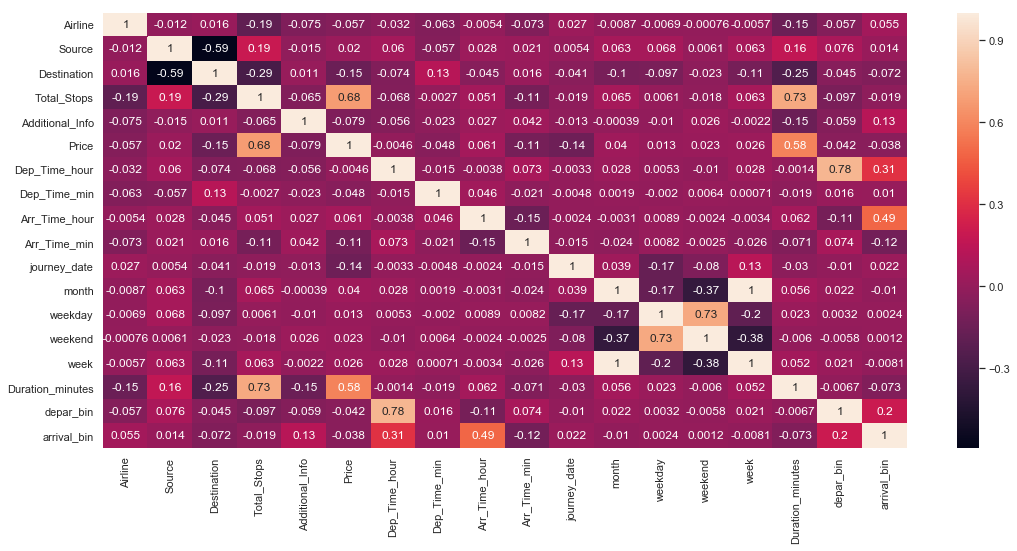

In [19]:
sns.set(font_scale=1)
plt.figure(figsize=(18,8))
sns.heatmap(df.corr(),annot=True)

## `week & month have correlation=1, Hence will drop one of them`

In [20]:
x=df.drop(columns=['Price','week']) 
test=test.drop(columns='week') 
y=df['Price']

x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=100)
print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)

x.head()

(8370, 16) (8370,)
(2093, 16) (2093,)


,Airline,Source,Destination,Total_Stops,Additional_Info,Dep_Time_hour,Dep_Time_min,Arr_Time_hour,Arr_Time_min,journey_date,month,weekday,weekend,Duration_minutes,depar_bin,arrival_bin
0,3,0,5,0,7,22,20,1,10,24,3,6,1,170,3,3
1,1,3,0,2,7,5,50,13,15,1,1,5,1,445,0,1
2,4,2,1,2,7,9,25,4,25,9,9,4,0,1140,0,0
3,3,3,0,1,7,18,5,23,30,12,12,3,0,325,2,3
4,3,0,5,1,7,16,50,21,35,1,1,3,0,285,2,3


# K-Fold Cross Validation

In [21]:
kfold = KFold(n_splits=5,shuffle=True,random_state=100)

results = pd.DataFrame(columns=['model','mean error','median error','error score'])

models_name = ['linear regression','KNN','SVM(rbf)','decision tree','RandomForest','AdaBoost',
                'xgboost','gradientboost','bagging','lgbm']

model_list = [LinearRegression(),KNeighborsRegressor(),SVR(),DecisionTreeRegressor(), RandomForestRegressor(),
              AdaBoostRegressor(),XGBRegressor(),GradientBoostingRegressor(),BaggingRegressor(),LGBMRegressor()]

for idx,model in enumerate(model_list):
    score=cross_val_score(model,x_train,y_train,scoring='neg_mean_squared_log_error',cv=kfold,n_jobs=-1,verbose=1)
    results.loc[idx] = [models_name[idx],score.mean(),np.median(score),score]

results.sort_values(by='median error',inplace=True,ascending=False)
results

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5

,model,mean error,median error,error score
9,lgbm,-0.001087,-0.001053,"[-0.0010084745143928119, -0.0010084716811793544, -0.0010525230037094595, -0.0011705641364878538, -0.0011966113047024499]"
8,bagging,-0.001266,-0.001210,"[-0.0010760497088747878, -0.0011213638686319869, -0.0012103374432953582, -0.0014292126580696003, -0.0014923014398315702]"
4,RandomForest,-0.001253,-0.001224,"[-0.0011000808037371227, -0.0011271916700712034, -0.0012242005793013772, -0.0014360428811494167, -0.0013770881798117615]"
7,gradientboost,-0.001864,-0.001857,"[-0.0018573582319927234, -0.001737613424174757, -0.0018162240283720098, -0.0019990123344886656, -0.0019106347412841153]"
6,xgboost,-0.001883,-0.001875,"[-0.001874546414863989, -0.0017728354221066374, -0.0018368809025269015, -0.002026679717598668, -0.0019038928048929484]"
3,decision tree,-0.001937,-0.001939,"[-0.0018511553232027054, -0.0018379483259667391, -0.002061831387668847, -0.0019394946666860568, -0.001996310203781378]"
1,KNN,-0.003443,-0.003470,"[-0.003120890842969784, -0.003474132478821255, -0.0034698368000348387, -0.0037298560866704635, -0.0034184367647397233]"
5,AdaBoost,-0.004834,-0.004923,"[-0.005221540315614919, -0.004923391229096647, -0.004272818744246234, -0.00528806695298208, -0.004463372236896776]"
0,linear regression,-0.005393,-0.005294,"[-0.005272494310869591, -0.00515475409963383, -0.005293849078753468, -0.005860124355935521, -0.005384234858428004]"
2,SVM(rbf),-0.007143,-0.007145,"[-0.007145379794493372, -0.007072490668532681, -0.007243382063824635, -0.007414025695048585, -0.006837531631120541]"


# Tuning HyperParameters of LGBMRegressor using GridSearchCV

In [22]:
# folds = KFold(n_splits = 5, shuffle = True, random_state = 100)

# params={'num_leaves':[i for i in range(40,101,2)],'learning_rate':[0.1,0.05],'n_estimators':[i for i in range(300,501,20)]}

# model_cv = GridSearchCV(LGBMRegressor(),params,scoring= 'neg_mean_squared_log_error',cv=folds,verbose = 1,
#                         return_train_score=True,n_jobs=-1) 

# model_cv.fit(x_train, y_train)

# print(model_cv.best_params_)
# print(model_cv.best_score_)

# gscv_results=pd.DataFrame(model_cv.cv_results_)
# print('error on test data {}'.format(mean_squared_log_error(y_test,model_cv.predict(x_test))))

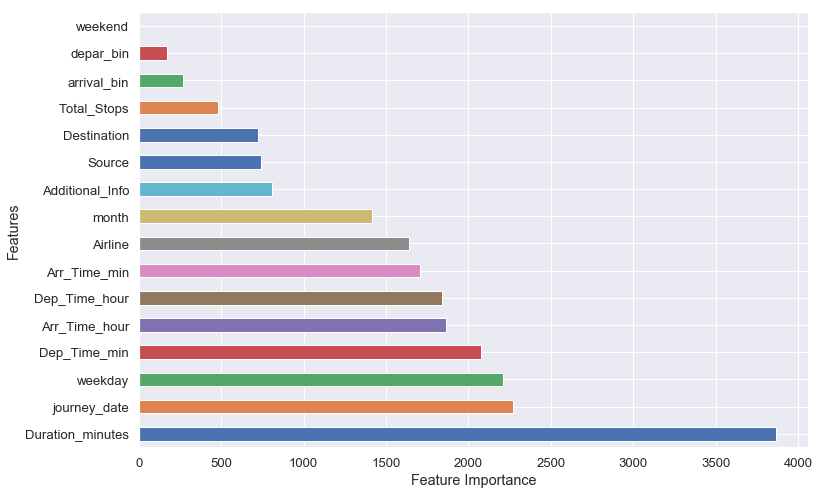

In [23]:
model=LGBMRegressor(num_leaves=48,n_estimators=470,learning_rate=0.1)
model.fit(x,y)

#inv_boxcox(x_bc,lam)
ans = pd.DataFrame({'Price':inv_boxcox(model.predict(test),lam)})
ans.to_excel('answer.xlsx',index=None)  # FOR MAKING SUBMISSION FILE

plt.figure(figsize=(12,8))
sns.set(font_scale=1.2)
feat_importances = pd.Series(model.feature_importances_, index=x_train.columns)
feat_importances.nlargest(x_train.shape[1]).plot(kind='barh'); # plots importance of all features
plt.ylabel('Features')
plt.xlabel('Feature Importance');

# Using RFE(Recursive Feature Elimination) for finding Optimal Features 

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  4.8min finished


{'n_features_to_select': 13}
-0.0008409579007403225


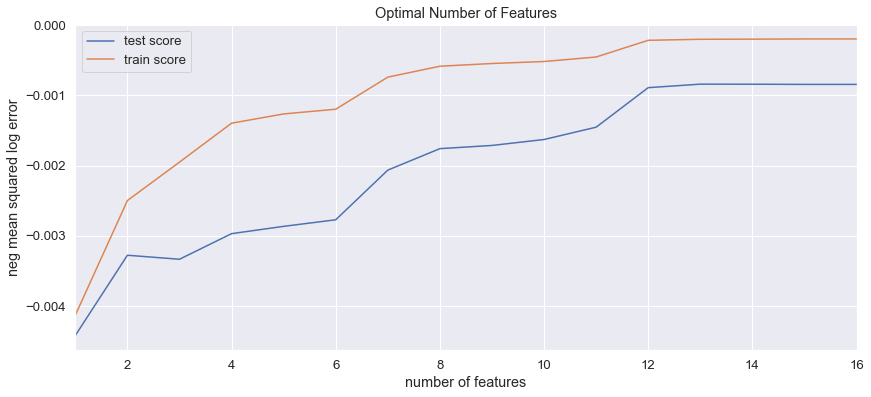

In [24]:
# step-1: create a cross-validation scheme
kfold = KFold(n_splits=5,shuffle=True,random_state=100)

# step-2: specify range of hyperparameters to tune
hyperparams = {'n_features_to_select':list(range(1,len(x_train.columns)+1))}

# step-3 specify model
lgbm=LGBMRegressor(num_leaves=48,n_estimators=470,learning_rate=0.1)
lgbm.fit(x_train,y_train)
rfe = RFE(lgbm)

# step-4 perform grid search
model_gscv=GridSearchCV(rfe,param_grid=hyperparams,scoring='neg_mean_squared_log_error',verbose=1,
                        cv=kfold,return_train_score=True,n_jobs=-1)

# fit the model
model_gscv.fit(x_train, y_train) 

gscv_results=pd.DataFrame(model_gscv.cv_results_)

print(model_gscv.best_params_)
print(model_gscv.best_score_)

plt.figure(figsize=(14,6))
sns.set(font_scale=1.2)
plt.plot(gscv_results["param_n_features_to_select"], gscv_results["mean_test_score"])
plt.plot(gscv_results["param_n_features_to_select"], gscv_results["mean_train_score"])
plt.xlabel('number of features')
plt.ylabel('neg mean squared log error')
plt.title("Optimal Number of Features")
plt.legend(['test score', 'train score'], loc='upper left')
plt.xlim([1,len(x_train.columns)])
plt.grid(True)

In [25]:
rfe = RFE(LGBMRegressor(num_leaves=48,n_estimators=470,learning_rate=0.1),n_features_to_select=13)
rfe.fit(x,y)
print('Columns not needed',set(x.columns)-set(x.columns[rfe.support_]))

Columns not needed {'weekend', 'depar_bin', 'arrival_bin'}


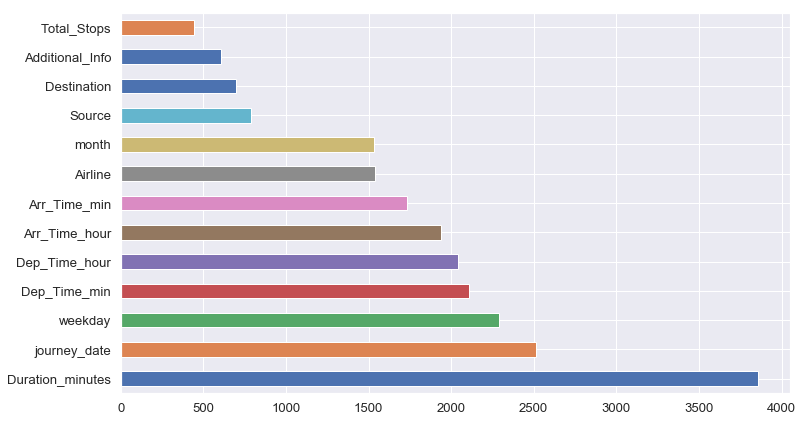

In [26]:
x=df.drop(columns=['Price','week','depar_bin', 'weekend', 'arrival_bin'])
test=test.drop(columns=['depar_bin', 'weekend', 'arrival_bin']) # since 'week' column was already dropped earlier
y=df['Price']

model=LGBMRegressor(num_leaves=48,n_estimators=470,learning_rate=0.1)
model.fit(x,y)
ans = pd.DataFrame({'Price':inv_boxcox(model.predict(test),lam)})
ans.to_excel('answer.xlsx',index=None) # FOR MAKING SUBMISSION FILE

plt.figure(figsize=(12,7))
feat_importances = pd.Series(model.feature_importances_, index=x.columns)
feat_importances.nlargest(x.shape[1]).plot(kind='barh');

# `LeaderBoard Ranking was better when all Features were used`

In [42]:
from IPython.display import Image
Image(filename='leaderboard.PNG',width=800,height=20)

# `Rank 67 out of 360+ Participants :)`

# FURTHER IMPROVEMENTS

<div class="alert alert-block alert-warning">
<ul style="font-size:18px;color:red"> 
    <li> Doing better feature engineering (considering holidays,climatic conditions, etc...)</li>
     <br>
     <li> Stacking Different Models </li>
     <br>
     <li> Fine Tuning All Hyperparameters using GridSearchCV </li>
 </ul>
 </div>



#  THANK YOU !! 